Durante uma das aulas de inferência causal, o professor Rafael Stern nos apresentou o cenário de estimação de densidade condicional para estimação do efeito causal utilizando o critério frontdoor.

O problema de quantificação da incerteza de uma previsão não me era novo, já tinha estudado um pouco sobre conformal predictions, onde se tenta estimar intervalos de confança para suas estimativas. Mas esse problema é naturalmente ainda mais complexo pois estamos tentando entender com mais profundidade os possíveis valores que meu alvo pode tomar.

Como achei o problema interessante, e a técnica apresentada (FlexCode) super elegante, achei que fazia sentido escrever um pouco sobre por aqui.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import pandas as pd

plt.rcParams.update({'font.size': 8})

## Conditional Density Estimation

When we attempt to model the relationship between a target variable Y and one or more covariables X we are usually trying to model a conditional-expectation type relationship. Matemáticamente, se a sua loss for o erro quadrático médio, estamos explicitamente tentando achar a função $\mathbb{E} \left( Y | X\right)$. Essa função naturalmente nos retorna uma previsão do valor médio de Y quando as covariáveis são X. Apesar de muito útil para muitas aplicações, essa estimativa não conta toda a história que podemos estar interessados. Será que a variância ao redor desse valor médio é muito grande? Ou podemos confiar de que certamente o valor será próximo do valor previsto? While point estimates provide a quick and simple summary of expected outcomes, they often miss out on the rich complexity and uncertainty inherent in most real-world prediction tasks.

A área de conformal predictions tenta lidar com essa incerteza estimando intervalos de confiança $IC(X)$ ao redor das previsões do modelo de forma que $\textrm{y_true} \in IC(X)$ com alguma significância(?) desejada. Interpretar o intervalo de confiança começa a responder algumas das perguntas possíveis que levantamos anteriormente. Entretanto ter os extremos do intervalo apenas (que naturalmente são tentativas de estimar os quantis condicionais) não contam toda a história da incerteza associada à sua previsão, como, por exemplo, densidades multimodais.

Conditional Density Estimation (CDE) is focused on predicting an entire distribution of potential outcomes given some input data, rather than just a single point estimation. Matematicamente, estamos estimando a função densidade de probabilidade $f \left( Y | X\right)$.

The comprehensive nature of CDE provides a rich understanding of the data's characteristics, and can be particularly beneficial in addressing two crucial aspects: catering to multi-modal outcomes and understanding model trustworthiness.

1. **Multi-modal outcomes:** Traditional regression or classification problems, which typically focus on single point predictions, often fail to capture the full complexity of real-world phenomena. This is especially evident when a single input can feasibly result in multiple valid outputs, a situation we refer to as multi-modality. For instance, consider a task like turning sketches into colored images. For any given sketch, there are multiple equally plausible colored images. By providing a full distribution of possible outcomes, CDE effectively captures these multiple modes, giving a richer and more realistic model of such scenarios.

2. **Model Trustworthiness:** Point estimation predictions do not provide any sense of their own reliability or uncertainty. In contrast, CDE provides a full distribution of potential outcomes, which inherently contains information about prediction confidence. The predicted distribution's width can serve as a measure of uncertainty or confidence. This feature can give users a more nuanced understanding of predictions, which is vital when making decisions based on those predictions. For example, in healthcare, a prediction about patient outcomes that comes with an understanding of confidence or uncertainty can lead to more informed and appropriate medical decisions.

## Example

Vamos construir um problema simples de exemplo para discutir o problema de CDE aplicando técnicas não-paramétricas. Imagine um processo gerador de dados da forma 

$$X\sim\textrm{Uniform}(0, 1),$$

$$Y | X \sim \sin(2\pi X) + \mathcal{N}(0, \sigma(X)),$$

com $\sigma(X) = 0.3 - 0.25 \sin(2\pi X)$.

In [2]:
def mean_function(X):
    return np.sin(2 * np.pi * X)

def deviation_function(X):
    return 0.3 + 0.25 * mean_function(X)

def generate_data_with_normal_noise(mean_generator, deviation_generator, size=5_000, random_state=None):
    def normal_noise_generator(X, deviation_generator, random_state=None):
        noise = np.random.RandomState(random_state).normal(loc=0, scale=deviation_generator(X))
        return noise
    
    rs = np.random.RandomState(random_state).randint(0, 2 * 32 - 1, size=2)
    X = np.random.RandomState(rs[0]).uniform(size=size)
    y_pred = mean_generator(X=X)
    noise = normal_noise_generator(X=X, deviation_generator=deviation_generator, random_state=rs[1])
    y_pred_noisy = y_pred + noise
    
    return X, y_pred_noisy

In [3]:
X, y = generate_data_with_normal_noise(mean_generator=mean_function, deviation_generator=deviation_function, random_state=42)

Naturamente, pela construção dos dados, a densidade condicional depende das covariáveis tanto na média quanto na variância.

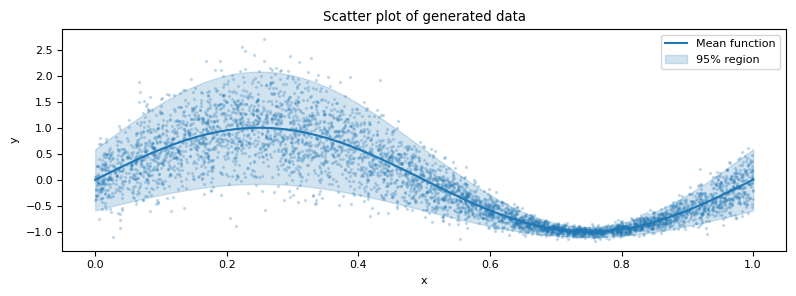

In [4]:
x_grid = np.linspace(0, 1, 1000)

fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(x_grid, mean_function(x_grid), color="C0", label="Mean function")
ax.fill_between(x_grid, mean_function(x_grid) - 1.96 * deviation_function(x_grid), mean_function(x_grid) + 1.96 * deviation_function(x_grid), color="C0", alpha=0.2, label="95% region")
ax.scatter(X, y, s=2, color="C0", alpha=0.2)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Scatter plot of generated data")
ax.legend()
plt.tight_layout()

## Histograma

O histograma é uma estimativa de densidade quando normalizado para ter integral 1. Entretanto utilizar todas as amostras nos dá uma estimativa da densidade de $Y$ sem nenhuma condicional.

Podemos condicionar essa estratégia rapidamente filtrando apenas pontos que estão próximos de $X=x$ quando criamos o histograma que vai representar aquela densidade condicional. A definição de pontos próximos pode varia, pode ser por exemplo selecionando apenas os exemplos que estão em um raio de $\varepsilon$ ao redor do ponto $x$ ou usando alguma noção de vizinhos mais proxímos.

In [5]:
from scipy.stats import rv_histogram, norm
hist = np.histogram(y, bins=np.linspace(- 1.5, 3, 51))
hist_dist = rv_histogram(hist)

def plot_conditional_y_using_near_data(ax, x_value, X, y, c, eps=0.05):
    ax.plot(y_grid_refined, norm(loc=mean_function(x_value), scale=deviation_function(x_value)).pdf(y_grid_refined), "--", color=c, label=f"real $f(y | x = {x_value})$")
    ax.hist(y[(X < x_value + eps) & (X > x_value - eps)], alpha=0.3, bins=y_grid, density=True, color=c, label=f"estimated $f(y | x = {x_value})$ using near data")

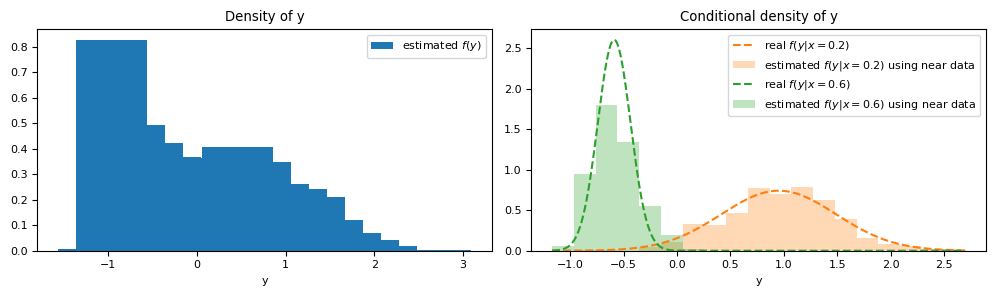

In [6]:
min_y, max_y = min(y), max(y)
y_grid = np.linspace(min_y, max_y, 20)
y_grid_refined = np.linspace(min_y, max_y, 1000)

fig, ax = plt.subplots(ncols=2, figsize=(10, 3))
ax[0].bar(y_grid, hist_dist.pdf(y_grid), label="estimated $f(y)$")
ax[0].set_title("Density of y")
ax[0].set_xlabel("y")
ax[0].legend()

plot_conditional_y_using_near_data(ax=ax[1], x_value=0.2, X=X, y=y, c="C1")
plot_conditional_y_using_near_data(ax=ax[1], x_value=0.6, X=X, y=y, c="C2")
ax[1].set_title("Conditional density of y")
ax[1].set_xlabel("y")
ax[1].legend()

plt.tight_layout()

## Kernel Density Estimation (KDE)

Por outro lado, o problema de estimação de densidade não-paramétrica costuma ser resolvido utilizando o KDE e faz sentido utilizar ele aqui também alinhado à alguma forma de transformar o problema em uma estimação condicional. O long story short do KDE é colocar bumps ao redor de pontos observados (com o formato de uma gaussiana, por exemplo) e somar esses bumps normalizando eles para ter uma estimativa da densidade.


$\oint$ _O tipo de bump (que é chamado de kernel) e a bandwidth deles são alguns hiperparâmetros que você pode ajustar utilizando validação cruzada com uma métrica estilo verossimilhança para ver se uma amostra de teste realmente é verossimil de ter sido amostrada da sua densidade estimada. Veja mais sobre isso em [3](https://jakevdp.github.io/PythonDataScienceHandbook/05.13-kernel-density-estimation.html)_

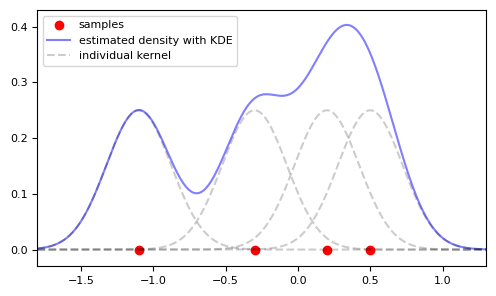

In [7]:
def gaussian_kernel(x, y):
    return np.exp(- (x - y)**2 / 0.1)

def kde(x, S):
    return sum(gaussian_kernel(x, s) for s in S)

S = [-1.1, -0.3, 0.2, 0.5]
grid_kde = np.linspace(-1.8, 1.3, 1000)

fig, ax = plt.subplots(figsize=(5, 3))

ax.scatter(S, [0] * len(S), c='r')
ax.plot(grid_kde, kde(grid_kde, S)/len(S), c='b', alpha=0.5)
[ax.plot(grid_kde, gaussian_kernel(grid_kde, s) / len(S), '--', c='k', alpha=0.2) for s in S]
ax.set_ylim(-0.03, 0.43)
ax.set_xlim(-1.8,1.3)
ax.legend(["samples", "estimated density with KDE", "individual kernel"])
plt.tight_layout()

Para condicionar essa técnica, podemos novamente usar algum tipo de NearestNeighbors (tanto selecionando o número de vizinhos, quanto selecionando o raio).

Utilizando o `NearestNeighbors` e o `KernelDensity` sem se preocupar muito com os hiperparâmetros desse modelo conseguimos encontrar os vizinhos mais pertos de um determinado ponto, por exemplo $X=0.2$ e em seguida utilizar o KDE com esse vizinhos para estimar a densidade.

In [8]:
from sklearn.neighbors import NearestNeighbors, KernelDensity

x_value = 0.2
knn = NearestNeighbors(n_neighbors=100).fit(X.reshape(-1, 1))
_, ind_x_value = knn.kneighbors([[x_value]])

kde = KernelDensity(kernel='gaussian', bandwidth="scott").fit(y[ind_x_value].reshape(-1, 1))

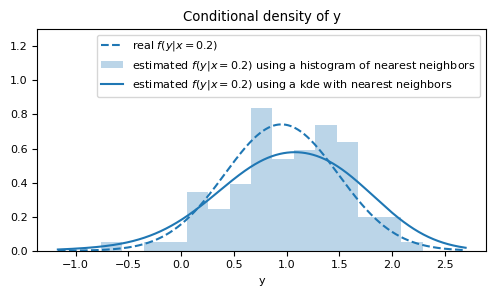

In [9]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(y_grid_refined, norm(loc=mean_function(x_value), scale=deviation_function(x_value)).pdf(y_grid_refined), "--", color="C0", label=f"real $f(y | x = {x_value})$")
ax.hist(y[ind_x_value].ravel(), alpha=0.3, bins=y_grid, density=True, color="C0", label=f"estimated $f(y | x = {x_value})$ using a histogram of nearest neighbors")

ax.plot(y_grid_refined, np.exp(kde.score_samples(y_grid_refined.reshape(-1, 1))), color="C0", label=f"estimated $f(y | x = {x_value})$ using a kde with nearest neighbors")
ax.set_title("Conditional density of y")
ax.set_xlabel("y")
ax.set_ylim(0, 1.3)
ax.legend()
plt.tight_layout()

Podemos colocar essa lógica em uma classe com a API do scikit-learn fazendo com que o `.predict` faça essa lógica anterior para cada valor pedido (ou seja, primeiro buscar os vizinhos e em sequência utilizar um KDE para ter as estimações para cada exemplo).

In [10]:
from sklearn.base import BaseEstimator, clone

class ConditionalNearestNeighborsKDE(BaseEstimator):
    """
    A class to perform Conditional Kernel Density Estimation using
    nearest neighbors.

    This class implements a Conditional Kernel Density Estimation
    (KDE) method that employs the concept of nearest neighbors.
    It allows the use of user-specified nearest neighbor and kernel
    density estimators or, if not provided, defaults will be used.

    Parameters
    nn_estimator : NearestNeighbors object, optional
    A pre-configured instance of a NearestNeighbors class to use
    for finding nearest neighbors. If not specified, a NearestNeighbors
    instance with n_neighbors=100 will be used.

    kde_estimator : KernelDensity object, optional
    A pre-configured instance of a KernelDensity class to use for
    estimating the kernel density. If not specified, a KernelDensity
    instance with bandwidth="scott" will be used.

    Methods
    fit(X, y)
    Fit the model to the data. 'X' are the input features and 'y' are
    the target values.

    predict(X)
    Predict the conditional kernel density for each point in 'X'.
    """
    def __init__(self, nn_estimator=None, kde_estimator=None):
        self.nn_estimator = nn_estimator
        self.kde_estimator = kde_estimator
        
    def fit(self, X, y):
        if self.nn_estimator is None:
            self.nn_estimator_ = NearestNeighbors(n_neighbors=100)
        else:
            self.nn_estimator_ = clone(self.nn_estimator)
        self.nn_estimator_.fit(X)
        self.y_train_ = y
        return self
    
    def predict(self, X):
        _, ind_X = self.nn_estimator_.kneighbors(X)
        if self.kde_estimator is None:
            return [KernelDensity(bandwidth="scott").fit(self.y_train_[ind].reshape(-1, 1)) for ind in ind_X]
        return [clone(self.kde_estimator).fit(self.y_train_[ind].reshape(-1, 1)) for ind in ind_X]

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [12]:
ckde = ConditionalNearestNeighborsKDE().fit(X_train.reshape(-1, 1), y_train)
ckde_preds = ckde.predict(X_test.reshape(-1, 1))

## Avaliando

Mas como avaliar esse problema. Claramente as métricas usuais de regressão são dificeis de serem aplicadas. Algumas métricas de conformal prediction até podem ser utilizadas aqui como a "quantas vezes a target observada cai no intervalo estimado", se você fizer intervalos de confiança a partir das densidades condicionais estimadas, mas o problema aqui é diferente e faz sentido abordar ele com métricas inerentes do problema.


Seja $f(y | x)$ a densidade de probabilidade condicional real do problema, e $\hat{f}(y | x)$ a densidade estimada, estamos querendo de fato ver o quão próxima essas duas funções estão, com o detalhe de que não temos $f(y | x)$. Uma forma esperta de lidar com isso é calcular o erro médio quadrático:

$$ L(f, \hat{f}) =  \int \int \left( \hat{f}(y | x) - f(y | x) \right)^2 d\mathbb{P}(x) dy.$$

Fazendo a distributiva ficamos com

$$ L(f, \hat{f}) = \int \int \left( \hat{f}(y | x) \right)^2 d\mathbb{P}(x) dy + \int \int -2\hat{f}(y | x) f(y, x) dx dy + C,$$

em que $C = \int \int \left( f(y | x) \right)^2 d\mathbb{P}(x) dy$ é uma constante que independe do método de estimação de $\hat{f}$ logo pode ser ignorada quando fazemos comparação entre modelos.

O primeiro termo pode ser calculado analiticamente enquanto o segundo pode ser estimado como

$$ \frac{-2}{n} \sum_{i=1}^n \hat{f}(y_i | x_i) $$

com uma amostra $S=(x_i, y_i)_{i=1}^n$ de validação.

Temos portanto uma métrica de comparação de modelos dada por 

$$ L(f, \hat{f}, S) = \int \int \left( \hat{f}(y | x) \right)^2 d\mathbb{P}(x) dy - \frac{2}{n} \sum_{i=1}^n \hat{f}(y_i | x_i),$$

em que queremos minimizar ela.

Podemos implementá-la de forma que receba as estimativas de densidade anteriormente calculadas e faça as operações necessárias (tanto a integração quanto o somatório). Para a integral estamos explicitamente pedindo um grid onde ela será calculada.

In [13]:
from sklearn.metrics import auc, make_scorer
from joblib import Parallel, delayed

def squared_loss(y_true, cde_preds, y_grid, n_jobs=-1):
    """
    Computes the average squared loss between the true and predicted
    conditional probabilities.

    This method calculates the squared loss for each pair of true and
    predicted conditional PDF (probability density function) values.
    The average of these losses is then returned. This method can be
    used to assess the quality of the conditional PDF fit.

    Parameters
    ----------
    y_true : array-like
    The true values of y for each sample.

    cde_preds : list of sklearn.neighbors.KernelDensity objects
    The predicted conditional PDFs. Each instance should be a
    KernelDensity object fitted to some data.

    y_grid : array-like
    The grid of y values used for computing the area under the curve
    (AUC) for the squared PDF.

    n_jobs : int, optional
    The number of jobs to run in parallel. '-1' means using all
    processors.

    Returns
    -------
    float
    The average squared loss between the true and predicted conditional PDFs.
    """
    def _compute_individual_loss(y_, cde_pred):
        # The score_samples and score methods returns stuff on log scale,
        # so we have to exp it.
        squared_auc = auc(y_grid, np.exp(cde_pred.score_samples(y_grid.reshape(-1, 1)))**2)
        expected_value = np.exp(cde_pred.score([[y_]]))
        return squared_auc - 2 * expected_value

    loss = Parallel(n_jobs=n_jobs)(
        delayed(_compute_individual_loss)(y_, cde_pred) for y_, cde_pred in zip(y_true, cde_preds)
    )

    return sum(loss) / len(y_true)

Aplicando ela nos dados anteriores temos uma forma de quantificar o quão bem estamos realizando a tarefa de CDE.

In [14]:
squared_loss(y_test, ckde_preds, np.linspace(-5, 5, 1000))

-0.8507158015517423

Para efeito de comparação, podemos comparar com a estimação de densidade de $Y$ sem levar em conta a condicional, ou seja, podemos treinar o KDE em todos os dados de treino.

In [15]:
squared_loss(y_test, len(y_test)*[KernelDensity(bandwidth="scott").fit(y_train.reshape(-1, 1))], np.linspace(-5, 5, 1000))

-0.4007238630119935

Como o valor anterior é menor, concluímos que ele é uma estimação de densidade melhor.

$\oint$ _Essa métrica é interessante para comparar modelos, mas pode ser difícil de interpretar do ponto de vista de negócios. Nesse caso, entendo que tentar transformar sua previsão de distribuição em uma previsão pontual para calcular alguma métrica tradicional como o [MAE] (ou mesmo métricas de conformal prediction) pode ser uma maneira de contornar o problema para ter uma métrica mais palatável._

Tendo uma forma de comparar modelos é natural querer otimizar os hiperparâmetros com um grid search por exemplo. Como construimos o ConditionalNearestNeighborsKDE seguindo o padrão do sklearn, e a métrica de forma que recebe o output de um `.predict`, podemos simplesmente utilizar o GridSearchCV para otimizar por exemplo como queremos que o `NearestNeighbors` seja.

In [16]:
from functools import partial
squared_loss_score = make_scorer(partial(squared_loss, y_grid=np.linspace(-5, 5, 1000)), greater_is_better=False)

In [17]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "nn_estimator": [NearestNeighbors(n_neighbors=n_neighbors) for n_neighbors in [100, 500, 1000]],
}

gs = (
    GridSearchCV(
        ConditionalNearestNeighborsKDE(),
        param_grid=param_grid,
        scoring=squared_loss_score)
    .fit(X_train.reshape(-1, 1), y_train)
)

In [18]:
(
    pd.DataFrame(gs.cv_results_)
    .filter(["param_nn_estimator", "mean_score_time", "mean_test_score", "std_test_score"])
    .sort_values(by="mean_test_score", ascending=False)
    .reset_index(drop=True)
)

,param_nn_estimator,mean_score_time,mean_test_score,std_test_score
0,NearestNeighbors(n_neighbors=500),3.387825,0.866858,0.015677
1,NearestNeighbors(n_neighbors=100),1.075202,0.845465,0.016176
2,NearestNeighbors(n_neighbors=1000),5.895975,0.699505,0.013646


Nesse caso, obtemos um score melhor que o anterior usando valores quaisquer de vizinhos. Podemos ainda nos importar com os aspectos da estimação de kernel e isso poderia melhorar ainda o resultado.

In [19]:
squared_loss(y_test, gs.best_estimator_.predict(X_test.reshape(-1, 1)), np.linspace(-5, 5, 1000))

-0.9276598435770342

Essa estrutura foi apresentada por ser mais intuitiva, entretanto em dimensões mais altas ou em cenários de muitos dados, a busca de vizinhos tem alguns problemas. Primeiro, ela é computacionalmente custosa pois envolve comparações de distâncis. Segundo, ficamos facilmente a mercê de variáveis pouco informativas em $X$ (que de forma geral é um vetor) e da curse of dimensionality (referencia), com nossos vizinhos ficam cada vez mais distantes e sendo pouco representativos. Num problema real você talvez tenha centenas de covariáveis que você pode ter interesse em condicionar e milhões de exemplos, então essa estratégia pode não ser a mais indicada.

## FlexCode

O FlexCode vem para tentar contornar esse problema abordando o CDE de uma maneira completamente diferente com argumentos de álgebra linear.

Estamos estimando uma função que naturalmente pode ser representada em uma base de funções ortonormais (botar umas referencias de serie de fourrier)...

In [20]:
from flexcode.regression_models import RandomForest
from flexcode import FlexCodeModel

# Instantiate and fit model
model = FlexCodeModel(RandomForest, max_basis=31, regression_params={'max_depth': 5, 'n_estimators': 100})
model.fit(X_train, y_train)

In [21]:
cdes, z_grid = model.predict(X_test, n_grid=400)
z_grid = z_grid.reshape(-1)

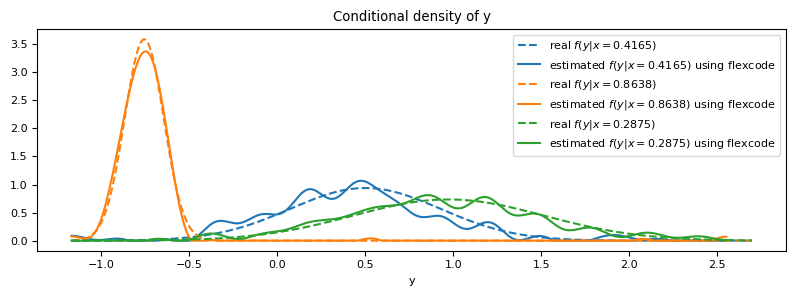

In [22]:
fig, ax = plt.subplots(figsize=(8, 3))

for c, sample_index in enumerate(np.random.RandomState(0).choice(len(X_test), size=3)):
    x_value = np.round(X_test[sample_index], 4)
    ax.plot(y_grid_refined, norm(loc=mean_function(x_value), scale=deviation_function(x_value)).pdf(y_grid_refined), "--", color=f"C{c}", label=f"real $f(y | x = {x_value})$")
    ax.plot(z_grid, cdes[sample_index], color=f"C{c}", label=f"estimated $f(y | x = {x_value})$ using flexcode")
ax.set_title("Conditional density of y")
ax.set_xlabel("y")
ax.legend()
plt.tight_layout()

In [23]:
class FlexCode_return_to_DensityEstimator:
    def __init__(self, y_grid, pdf_values):
        self.y_grid = y_grid
        self.pdf_values = pdf_values
        self.density = rv_histogram((pdf_values, np.hstack([y_grid, [y_grid[-1] + y_grid[-1] - y_grid[-2]]])))

    def score_samples(self, X):
        return np.log(self.density.pdf(X))
    
    def score(self, X):
        return np.sum(self.score_samples(X))

In [24]:
density_estimation_preds_flexcode = [FlexCode_return_to_DensityEstimator(y_grid=z_grid, pdf_values=cde) for cde in cdes]

In [25]:
squared_loss(y_test, density_estimation_preds_flexcode, np.linspace(-5, 5, 1000))

-1.633789362027814

In [26]:
# Outras métricas: encarar o problema irmão de conformal predictions e computar quantas vezes cai no intervalo de ocnfianca

Da pra fazer leaf embedding para achar os vizinhos. Mas acho que o post já tá muito grande.

Dá pra fazer o critério da random forest ser diretamente a squared loss ao inves do MSE: https://github.com/lee-group-cmu/RFCDE

___

Fazer um post antes sobre Leaf se não vai ficar muito jogado. Não precisa ser gigante aaa.

In [27]:
from sklearn.ensemble import RandomForestRegressor

class ConditionalRandomForestNearestNeighborsKDE(BaseEstimator):
    def __init__(self, rfr_estimator=None, nn_estimator=None, kde_estimator=None, random_state=None):
        self.rfr_estimator = rfr_estimator
        self.nn_estimator = nn_estimator
        self.kde_estimator = kde_estimator
        self.random_state = random_state
        
    def fit(self, X, y):
        if self.rfr_estimator is None:
            self.rfr_estimator_ = RandomForestRegressor(max_depth=10, random_state=self.random_state)
        else:
            self.rfr_estimator_ = clone(self.rfr_estimator)

        if self.nn_estimator is None:
            self.nn_estimator_ = NearestNeighbors(n_neighbors=100, metric="hamming")
        else:
            self.nn_estimator_ = clone(self.nn_estimator)

        self.rfr_estimator_.fit(X, y)
        leafs_X = self.rfr_estimator_.apply(X)
        self.nn_estimator_.fit(leafs_X)
        self.y_train_ = y
        return self
    
    def predict(self, X):
        leafs_X = self.rfr_estimator_.apply(X)
        _, ind_X = self.nn_estimator_.kneighbors(leafs_X)
        if self.kde_estimator is None:
            return [KernelDensity(bandwidth="scott").fit(self.y_train_[ind].reshape(-1, 1)) for ind in ind_X]
        return [clone(self.kde_estimator).fit(self.y_train_[ind].reshape(-1, 1)) for ind in ind_X]

In [28]:
crfkde = ConditionalRandomForestNearestNeighborsKDE().fit(X_train.reshape(-1, 1), y_train)
crfkde_preds = crfkde.predict(X_test.reshape(-1, 1))

squared_loss(y_test, crfkde_preds, np.linspace(-5, 5, 1000))

-0.848266403814976

Aqui a métrica tá igual porque a dimensão é baixa então ele deve praticamente coincidir com NN normal.

Porém num problema real:

In [29]:
from sklearn.datasets import fetch_california_housing

In [30]:
X_california, y_california = fetch_california_housing(return_X_y=True)
X_california_train, X_california_test, y_california_train, y_california_test = train_test_split(
    X_california, y_california, test_size=0.33, random_state=42)

In [32]:
%%time

ckde_california = ConditionalNearestNeighborsKDE().fit(X_california_train, y_california_train)
ckde_california_preds = ckde_california.predict(X_california_test)

squared_loss(y_california_test, ckde_california_preds, np.linspace(0, 6, 1000))

CPU times: total: 4.12 s
Wall time: 8.74 s


-0.2948159711962537

In [34]:
%%time

crfkde_california = ConditionalRandomForestNearestNeighborsKDE().fit(X_california_train, y_california_train)
crfkde_california_preds = crfkde_california.predict(X_california_test)

squared_loss(y_california_test, crfkde_california_preds, np.linspace(0, 6, 1000))

CPU times: total: 28.2 s
Wall time: 54.3 s


-0.6598829070523877

C:\Users\carlo\AppData\Local\anaconda3\lib\site-packages\joblib\_memmapping_reducer.py:607: UserWarning: Failed to delete temporary folder: C:\Users\carlo\AppData\Local\Temp\joblib_memmapping_folder_33240_e695207d42204ae69a5164fef977e13f_34395b25190f40d19809ad59b39b3314
  warnings.warn("Failed to delete temporary folder: {}"
C:\Users\carlo\AppData\Local\anaconda3\lib\site-packages\joblib\_memmapping_reducer.py:607: UserWarning: Failed to delete temporary folder: C:\Users\carlo\AppData\Local\Temp\joblib_memmapping_folder_33240_b642589d9c064c5185ae2cc0b5033905_4216d260f80b40259ba8963c6138b61e
  warnings.warn("Failed to delete temporary folder: {}"
C:\Users\carlo\AppData\Local\anaconda3\lib\site-packages\joblib\_memmapping_reducer.py:607: UserWarning: Failed to delete temporary folder: C:\Users\carlo\AppData\Local\Temp\joblib_memmapping_folder_33240_e695207d42204ae69a5164fef977e13f_18ff06d98ad24e678e7818f8502de50a
  warnings.warn("Failed to delete temporary folder: {}"
C:\Users\carlo\AppD

In [33]:
%%time

model_california = FlexCodeModel(RandomForest, max_basis=31, regression_params={'max_depth': 10, 'n_estimators': 100})
model_california.fit(X_california_train, y_california_train)

cdes_california, z_grid_california = model_california.predict(X_california_test, n_grid=400)
z_grid_california = z_grid_california.reshape(-1)
density_estimation_preds_flexcode_california = [FlexCode_return_to_DensityEstimator(y_grid=z_grid_california, pdf_values=cde) for cde in cdes_california]

squared_loss(y_california_test, density_estimation_preds_flexcode_california, np.linspace(0, 6, 1000))

CPU times: total: 8.53 s
Wall time: 1min 5s


-1.2748021561096443

___

TO DO:

- Fazer uma discussão bem breve sobre o LeafNeighbors antes de usar. Colocar isso antes do FlexCode pra linkar com o que tava falando ali em cima. Basicamente aqueles 2 pontos que tem no blog do Gui.

- Explicar o FlexCode.

- Traduzir.

- Garantir que tá no formato com links pros estimadores do sklearn.